In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

import tensorflow as tf
from keras import Model
from keras.layers import Dense, Input, Lambda

2022-03-09 23:46:50.922851: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  4


2022-03-09 23:46:57.187931: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-03-09 23:46:57.227058: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2022-03-09 23:46:57.228692: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:44:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2022-03-09 23:46:57.230374: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:84:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2

In [167]:
# n_paths
N = 1000000

# n_timesteps
M = 10

# time horizon
T = 1.0

# space dimension
d = 1

dt = T / M
X0 = 0.0
BATCH_SIZE = 128
EPOCHS = 1

In [168]:
# generate paths
dW = np.random.standard_normal((N, M))
# S0 = np.full((N, 1), X0)
S0 = np.random.random((N, 1)) * 10 - 5
S = np.cumsum(np.concatenate([S0, np.sqrt(dt) * dW], axis=1), axis=1)

In [169]:
def f(t, x, y, z):
    return 0

def F(t, x, y, z, h, Delta):
    return y - f(t, x, y, z) * h + tf.transpose(z) * Delta

In [170]:
def build_model(t, weights=None):

    inputs_x = Input(shape=(d,))
    inputs_dw = Input(shape=(d,))

    x = Dense(d + 10, activation="tanh")(inputs_x)
    x = Dense(d + 10, activation="tanh")(x)
    outputs_u = Dense(1)(x)
    model_u = Model(inputs_x, outputs_u)

    y = Dense(d + 10, activation="tanh")(inputs_x)
    y = Dense(d + 10, activation="tanh")(y)
    outputs_z = Dense(d)(y)
    model_z = Model(inputs_x, outputs_z)

    outputs = Lambda(lambda x: F(t, x[0], x[2], x[3], dt, x[1]))([inputs_x, inputs_dw, outputs_u, outputs_z])

    model_f = Model([inputs_x, inputs_dw], outputs)
    model_f.compile(loss="mse", optimizer="adam")

    # reuse weights from previous layer
    if weights is not None:
        model_f.set_weights(weights)

    return model_u, model_z, model_f

In [171]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


In [172]:
us = [lambda x: tf.exp(-x ** 2 / 4) / tf.sqrt(4 * tf.constant(math.pi, dtype=tf.float64))]
zs = [lambda x: -x / 2 * tf.exp(-x ** 2 / 4)]
fs = []

# with strategy.scope():
for i in tqdm(range(M - 1, -1, -1)):
    weights = fs[0].get_weights() if len(fs) > 0 else None
    model_u, model_z, model_f = build_model(dt * i, weights)
    history = model_f.fit([S[:, i], dW[:, i]], us[0](S[:, i + 1]), batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)
    us = [model_u] + us
    zs = [model_z] + zs
    fs = [model_f] + fs

  0%|          | 0/10 [00:00<?, ?it/s]

7813/7813 [==============================] - 12s 1ms/step - loss: 0.0329


 10%|█         | 1/10 [00:11<01:47, 11.92s/it]

7813/7813 [==============================] - 11s 1ms/step - loss: 4.7449e-04


 20%|██        | 2/10 [00:23<01:33, 11.73s/it]

7813/7813 [==============================] - 12s 1ms/step - loss: 4.3617e-04


 30%|███       | 3/10 [00:35<01:22, 11.80s/it]

7813/7813 [==============================] - 12s 1ms/step - loss: 3.8865e-04


 40%|████      | 4/10 [00:47<01:12, 12.05s/it]

7813/7813 [==============================] - 12s 1ms/step - loss: 3.6328e-04


 50%|█████     | 5/10 [01:00<01:00, 12.12s/it]

7813/7813 [==============================] - 12s 1ms/step - loss: 3.3880e-04


 60%|██████    | 6/10 [01:12<00:48, 12.20s/it]

7813/7813 [==============================] - 11s 1ms/step - loss: 3.1838e-04


 70%|███████   | 7/10 [01:23<00:35, 11.95s/it]

7813/7813 [==============================] - 11s 1ms/step - loss: 3.0359e-04


 80%|████████  | 8/10 [01:35<00:23, 11.79s/it]

7813/7813 [==============================] - 11s 1ms/step - loss: 2.9006e-04


 90%|█████████ | 9/10 [01:46<00:11, 11.67s/it]

7813/7813 [==============================] - 12s 1ms/step - loss: 2.7662e-04


100%|██████████| 10/10 [01:58<00:00, 11.85s/it]


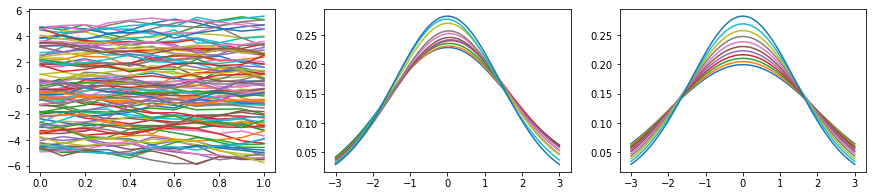

In [173]:
fig = plt.figure(figsize=(15, 3))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)

ax0.plot(np.linspace(0, T, M + 1), S[:100].T)

xs = np.linspace(-3, 3, 101)

# numerical
for u in us:
    ax1.plot(xs, u(xs))
    
# analytic
for i in range(M, -1, -1):
    t = T + dt * i
    ys = np.exp(-xs ** 2 / 4 / t) / np.sqrt(4 * math.pi * t)
    ax2.plot(xs, ys)

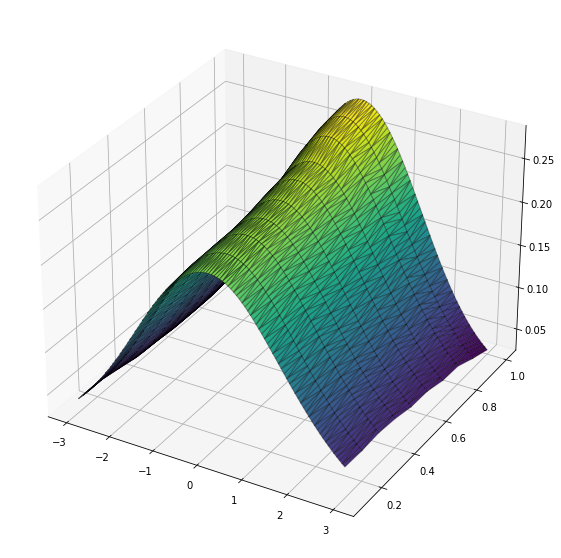

In [174]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

x = np.stack([xs for _ in range(1, M + 1)])
y = np.array([np.full((101,), dt * i) for i in range(1, M + 1)])
z = np.array([u(xs).numpy().reshape(-1, 1) for u in us[1:]])
ax.plot_trisurf(x.reshape(-1), y.reshape(-1), z.reshape(-1), cmap='viridis', edgecolor='#00000055')

fig.show()